**Installation**

In [1]:
import numpy as np
from numpy import pi

from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

**General QFT**

In [2]:
def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(pi/2**(n-qubit), qubit, n)
        
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

**Inverese QFT operation**

In [3]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

# 1. The above implementation of QFT was tested by preparing the Fourier state |5⟩ for which QFT†|5⟩=|101⟩. Try to find the state |a⟩ such that QFT†|a⟩=|100⟩

**It is clear that here a will be 4. We will verify that for a = 4, we get QFT output as 100.**

In [44]:
# Putting the qubit in the state |4>

nqubits = 3
number = 4
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw()

┌───┐ ┌──────┐
q_0: ┤ H ├─┤ P(π) ├
     ├───┤┌┴──────┤
q_1: ┤ H ├┤ P(2π) ├
     ├───┤├───────┤
q_2: ┤ H ├┤ P(4π) ├
     └───┘└───────┘

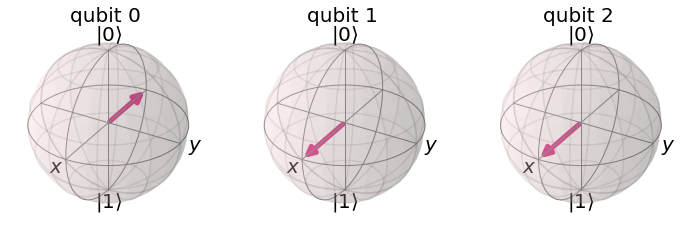

In [45]:
qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

In [46]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw()

┌─────────┐ ┌──────────┐   ┌───┐                                   »
   q_0: ┤ U2(0,π) ├─┤ U(0,0,π) ├─X─┤ H ├─■────────────────────────■────────»
        ├─────────┤┌┴──────────┤ │ └───┘ │P(-π/2) ┌───┐           │        »
   q_1: ┤ U2(0,π) ├┤ U(0,0,2π) ├─┼───────■────────┤ H ├─■─────────┼────────»
        ├─────────┤├───────────┤ │                └───┘ │P(-π/2)  │P(-π/4) »
   q_2: ┤ U2(0,π) ├┤ U(0,0,4π) ├─X──────────────────────■─────────■────────»
        └─────────┘└───────────┘                                           »
meas: 3/═══════════════════════════════════════════════════════════════════»
                                                                           »
«              ░ ┌─┐      
«   q_0: ──────░─┤M├──────
«              ░ └╥┘┌─┐   
«   q_1: ──────░──╫─┤M├───
«        ┌───┐ ░  ║ └╥┘┌─┐
«   q_2: ┤ H ├─░──╫──╫─┤M├
«        └───┘ ░  ║  ║ └╥┘
«meas: 3/═════════╩══╩══╩═
«                 0  1  2

In [47]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2022-01-26 21:46:01,961: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_bogota


In [48]:
shots = 1024
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)

Job Status: job has successfully run


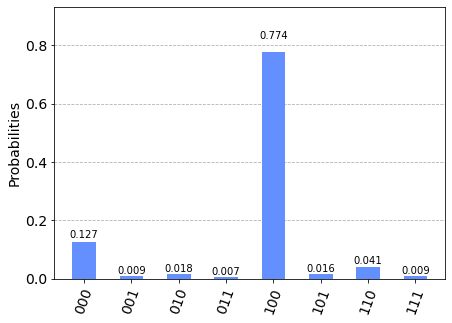

In [49]:
counts = job.result().get_counts()
plot_histogram(counts)

**We see that the highest probability outcome is 100, when we take a = 4**

# 2. Find the state |b⟩ such that QFT†|b⟩=|011⟩

**It is clear that here a will be 3. We will verify that for a = 3, we get QFT output as 011.**

In [50]:
# Putting the qubit in the state |4>

nqubits = 3
number = 3
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(3π/4) ├
     ├───┤├─────────┤
q_1: ┤ H ├┤ P(3π/2) ├
     ├───┤└┬───────┬┘
q_2: ┤ H ├─┤ P(3π) ├─
     └───┘ └───────┘

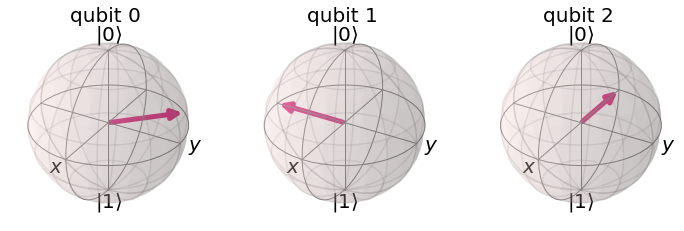

In [51]:
qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

In [52]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw()

┌─────────┐┌─────────────┐   ┌───┐                                   »
   q_0: ┤ U2(0,π) ├┤ U(0,0,3π/4) ├─X─┤ H ├─■────────────────────────■────────»
        ├─────────┤├─────────────┤ │ └───┘ │P(-π/2) ┌───┐           │        »
   q_1: ┤ U2(0,π) ├┤ U(0,0,3π/2) ├─┼───────■────────┤ H ├─■─────────┼────────»
        ├─────────┤└┬───────────┬┘ │                └───┘ │P(-π/2)  │P(-π/4) »
   q_2: ┤ U2(0,π) ├─┤ U(0,0,3π) ├──X──────────────────────■─────────■────────»
        └─────────┘ └───────────┘                                            »
meas: 3/═════════════════════════════════════════════════════════════════════»
                                                                             »
«              ░ ┌─┐      
«   q_0: ──────░─┤M├──────
«              ░ └╥┘┌─┐   
«   q_1: ──────░──╫─┤M├───
«        ┌───┐ ░  ║ └╥┘┌─┐
«   q_2: ┤ H ├─░──╫──╫─┤M├
«        └───┘ ░  ║  ║ └╥┘
«meas: 3/═════════╩══╩══╩═
«                 0  1  2

In [53]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2022-01-26 22:28:26,938: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_bogota


In [54]:
shots = 1024
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)

Job Status: job has successfully run


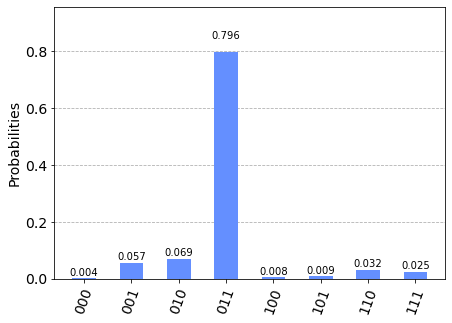

In [55]:
counts = job.result().get_counts()
plot_histogram(counts)

**We see that the highest probability outcome is 011, when we take a = 3**